# 2D FNO Training Predictions

**Authors**: Bernard Chang, Xuesong (Cedar) Ma, and Masa Prodanovic

**Last Updated**: Apr. 30, 2025

---
This notebook demonstrates the inference workflow of a 2D Fourier Neural Operator (FNO) model. The aim of the model is to predict the steady-state pressure field given a spatially-heterogeneous permeability input.

**Contents:**
- Data loading
- FNO model definition and configuration
- Evaluation on test data
- Visualization of predictions vs. ground truth
- Prediction on zero-shot resolution

---

## Import packages

In [ ]:
# System packages
import sys
import os
sys.path.append('..')
import glob
from pathlib import Path

# ML packages
import lightning as pl
from network.FNO2d import FNO2D

# Data processing
from dataloading import DarcyDataset
from torch.utils.data import DataLoader, random_split
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Configuration
from omegaconf import OmegaConf
cfg = OmegaConf.load("config.yaml")

# Set the seed for reproducibility
pl.seed_everything(cfg.seed)

Seed set to 185371


185371

## Load Test Dataset

We will first look at the test set we reserved from training. The training image size is $64\times64$.

In [ ]:
dataset = DarcyDataset('darcy_data_res.h5', resolution='resolution_64')

# Split the training dataset
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Split the dataset into training, validation, and test sets
_, _, test_dataset = random_split(dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Load the Trained Model

This is a pretrained model that is identical to the one saved from the training script. You can replace this with your own trained model if needed.

In [ ]:
# Load the trained model
model_dir = f"../saved_models/darcy/checkpoints"
model_loc = glob.glob(f'{model_dir}/*.ckpt')[0]
print(f'Loading {model_loc}')

# Instantiate the FNO2D model from the checkpoint
model = FNO2D.load_from_checkpoint(model_loc)

# Set the model to evaluation mode
model.eval()

Loading lightning_logs/version_0/checkpoints\epoch=49-step=3500.ckpt


FNO2D(
  (p): Linear(in_features=3, out_features=64, bias=True)
  (fno_blocks): ModuleList(
    (0-3): 4 x FourierBlock2D(
      (spectral_conv): SpectralConv2d()
      (w): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (q1): Linear(in_features=64, out_features=128, bias=True)
  (q2): Linear(in_features=128, out_features=1, bias=True)
)

## Make Test Predictions

In the following cells, we make predictions on the test dataset and visualize the predictions. To better visualize the model performance, we also compare the average radial spectral energy between the reference and predicted fields.

### Spectral Analysis

* Perform 2D FFT on reference & predicted pressure fields at each time step.
* Compute the energy spectrum $E(k_x, k_y) = |\hat{f}(k_x, k_y)|^2$
* Compute radial average to get 1D spectrum (for easier comparison)

In [ ]:
def compute_energy_spectrum(field):
    """
    Compute the energy spectrum of a 2D field using Fast Fourier Transform (FFT).

    This function calculates the energy spectrum by performing a 2D FFT on the input field,
    shifting the zero frequency component to the center, and computing the squared magnitude
    of the shifted FFT.

    Parameters:
    field (torch.Tensor): A 2D tensor of shape [H, W] representing the input field.

    Returns:
    numpy.ndarray: A 2D numpy array of shape [H, W] representing the energy spectrum of the input field.
    """
    fft2 = np.fft.fft2(field)
    fft2_shifted = np.fft.fftshift(fft2)
    energy = np.abs(fft2_shifted) ** 2
    return energy


def radial_average(energy):
    """
    Compute the radial average of a 2D energy spectrum.

    This function computes the average energy at each radial distance from the center 
    of a 2D field. It is commonly used to reduce a 2D power or energy spectrum to a 
    1D profile based on isotropic radial bins.


    Parameters:
        energy (numpy.ndarray): A 2D tensor of shape [H, W] representing the energy spectrum.

    Returns:
        numpy.ndarray: A 1D numpy array where each element contains the average energy at the corresponding radial distance from the center.
    """
    H, W = energy.shape
    center = (H // 2, W // 2)

    Y, X = np.ogrid[:H, :W]
    r = np.sqrt((X - center[1])**2 + (Y - center[0])**2).astype(np.int32)

    r_max = r.max()
    spectrum = np.bincount(r.ravel(), weights=energy.ravel()) / np.bincount(r.ravel())
    return spectrum


def plot_predictions(prediction):
    """
    Generate visualizations and an animated GIF comparing predicted and ground truth MCF evolution over time.

    For each time step, this function plots the:
        - Input permeability field
        - Reference pressure field
        - Predicted pressure field
        - Relative error heatmap
        - Radial spectral energy comparison

    Each time step is assembled them into an animated GIF.

    Parameters:
        prediction (dict): Output dictionary from lightning's `predict_step` containing:
            - "x" (torch.Tensor): Input permeability field
            - "y" (torch.Tensor): Reference pressure field
            - "yhat" (torch.Tensor): Model prediction

    Returns:
        None
    """
    x = prediction["x"][0, :, :].squeeze().cpu().numpy()
    y_true = prediction["y"][0, :, :].squeeze().cpu().numpy()
    y_pred = prediction["y_hat"][0, :, :].squeeze().cpu().numpy()
    
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 4, figure=fig)

    # Subplot for Input Permeability
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.set_title('Input Permeability')
    cax0 = ax0.imshow(x, cmap='plasma', vmin=0, vmax=1)
    fig.colorbar(cax0, ax=ax0, fraction=0.046, pad=0.04)


    # Subplot for True Pressure
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.set_title('True Pressure')
    cax1 = ax1.imshow(y_true, cmap='plasma', vmin=0, vmax=1)
    fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)

    # Subplot for Predicted Pressure
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.set_title('Predicted Pressure')
    cax2 = ax2.imshow(y_pred, cmap='plasma', vmin=0, vmax=1)
    fig.colorbar(cax2, ax=ax2, fraction=0.046, pad=0.04)

    # Subplot for Relative Error
    y_rel_err = np.abs(y_true - y_pred) / np.abs(y_true)
    y_rel_err[y_rel_err == np.inf] = 0
    y_rel_err[y_rel_err == -np.inf] = 0
    y_rel_err[y_rel_err == np.nan] = 0

    ax3 = fig.add_subplot(gs[0, 3])
    ax3.set_title('Relative Error')
    cax3 = ax3.imshow(y_rel_err, cmap='plasma', vmin=0, vmax=0.25)
    fig.colorbar(cax3, ax=ax3, fraction=0.046, pad=0.04)


    # Subplot for Spectral Comparison
    ax4 = fig.add_subplot(gs[1, 1:4])
    ax4.set_title('Radial Spectral Energy Comparison')
    # Compute 2D energy spectrum
    true_energy = compute_energy_spectrum(y_true)
    pred_energy = compute_energy_spectrum(y_pred)
    # Compute radial average of energy spectrum
    true_spectrum = radial_average(true_energy)
    pred_spectrum = radial_average(pred_energy)

    ax4.loglog(true_spectrum, label='Ground Truth')
    ax4.loglog(pred_spectrum, label='Prediction')
    ax4.set_xlabel('Frequency (radial wavenumber)')
    ax4.set_ylabel('Spectral Energy')
    ax4.legend()
    ax4.grid(True, which='both', ls='--')

    # Adjust layout to avoid overlap
    plt.tight_layout()

    

The following cell generates the predictions on the test dataset.

In [ ]:
# Initialize the Lightning trainer
trainer = pl.Trainer(logger=False, strategy='auto')

# Make predictions on the test dataset using the trained model
predictions = trainer.predict(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\ms-fno\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

The following cell visualizes the predictions for a specific sample ID. Move the slider to visualize predictions for different samples.

C:\Users\bcc2459\AppData\Local\Temp\ipykernel_7080\2792305694.py:64: RuntimeWarning: divide by zero encountered in divide
  y_rel_err = np.abs(y_true - y_pred) / np.abs(y_true)


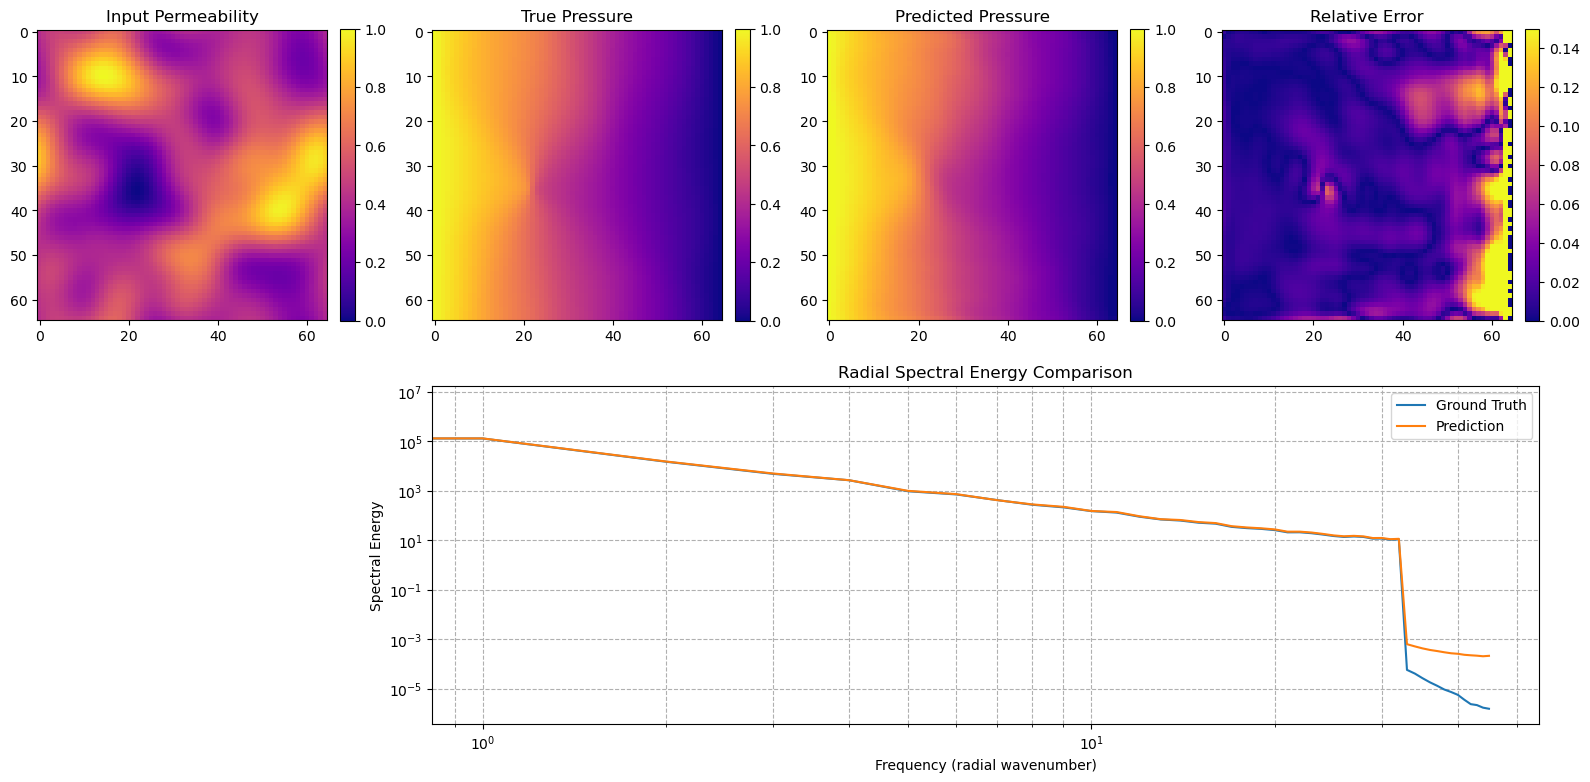

In [42]:
idx = 2
plot_predictions(predictions[idx])

### Zero-Shot Resolution Predictions

In this section, we use the trained FNO model to demonstrate zero-shot generalization by predicting Darcy flow solutions at resolutions not seen during training. These test samples preserve the same relative correlation lengths in the input permeability fields but differ in absolute image size.

In [ ]:
res = 512
# Resolutions: 32, 128, 256, 512
zeroshot_res_dataset = DarcyDataset('darcy_data_res.h5', resolution=f'resolution_{res}')

zeroshot_res_loader = DataLoader(zeroshot_res_dataset, batch_size=1, shuffle=False)
zeroshot_res_predictions = trainer.predict(model, dataloaders=zeroshot_res_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\bcc2459\AppData\Local\Temp\ipykernel_7080\2792305694.py:64: RuntimeWarning: divide by zero encountered in divide
  y_rel_err = np.abs(y_true - y_pred) / np.abs(y_true)


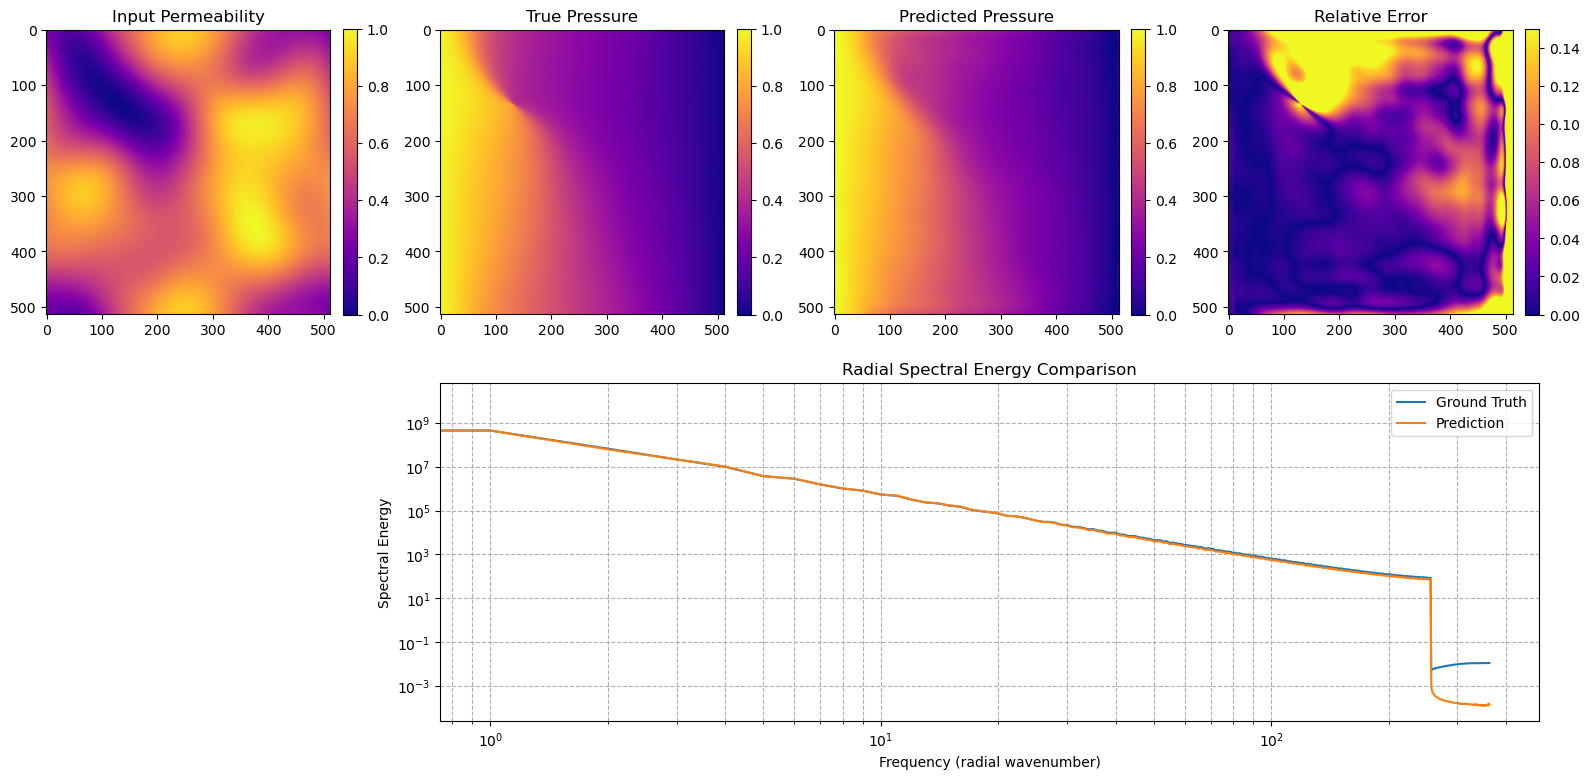

In [44]:
idx = 0
plot_predictions(zeroshot_res_predictions[idx])

### Zero-Shot Field of View Predictions

In this section, we evaluate the FNO model’s ability to generalize to larger spatial domains than seen during training — referred to here as zero-shot field of view. While the input permeability fields maintain the same relative correlation lengths, the physical domain size increases.

In [54]:
# Resolutions: 32, 128, 256, 512
fov_dataset = DarcyDataset('darcy_data_fov.h5', resolution='resolution_256')

fov_loader = DataLoader(fov_dataset, batch_size=1, shuffle=False)
fov_predictions = trainer.predict(model, dataloaders=fov_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\bcc2459\AppData\Local\Temp\ipykernel_7080\46979694.py:64: RuntimeWarning: divide by zero encountered in divide
  y_rel_err = np.abs(y_true - y_pred) / np.abs(y_true)


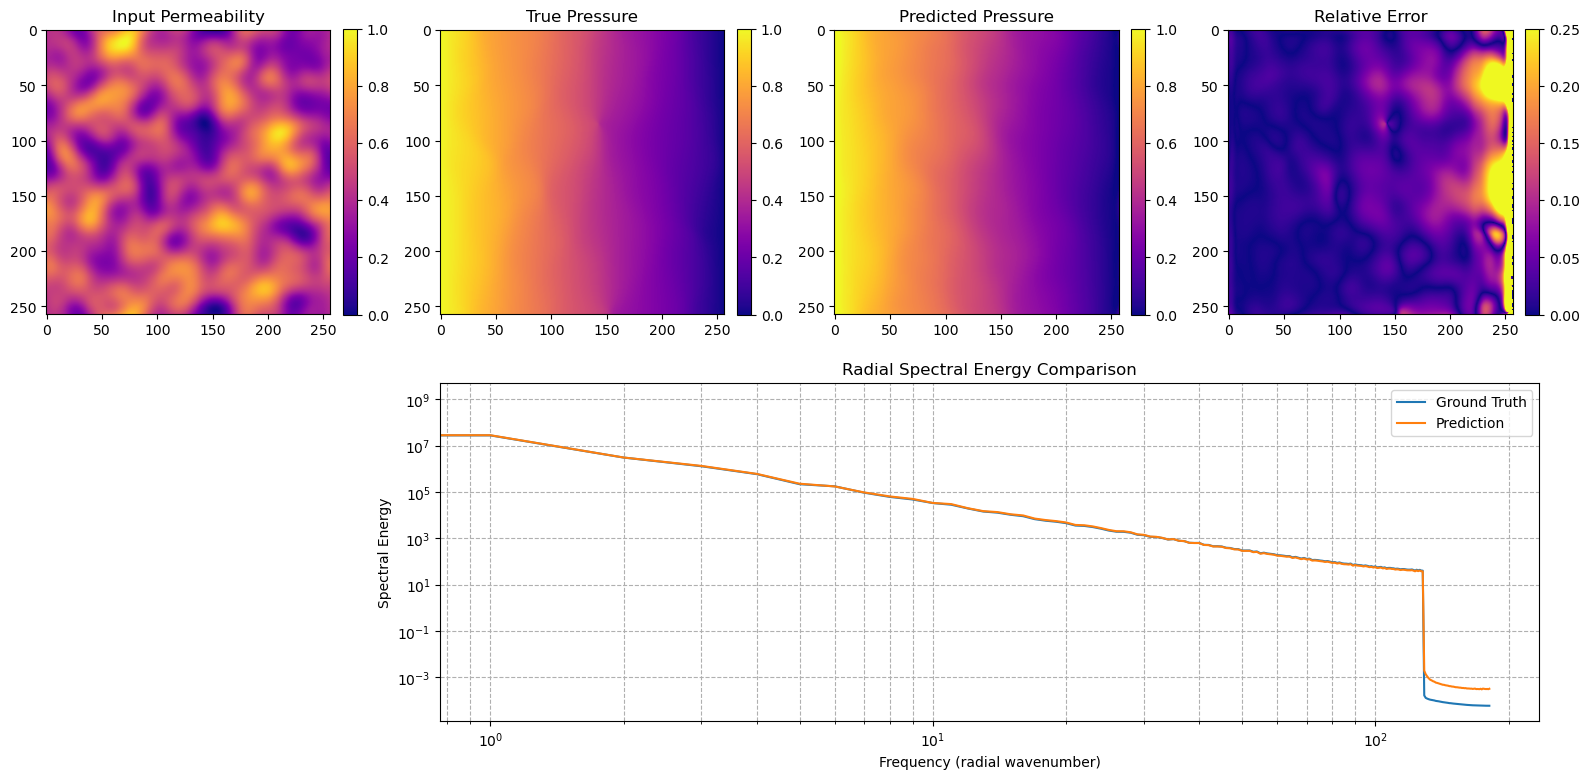

In [55]:
idx = 2
plot_predictions(fov_predictions[idx])

### ⚠️ Important caveats to zero-shot predictions:

FNOs learn to map functions between continuous spaces, and the model is trained using spectral (Fourier) representations rather than strictly grid-based convolution. Because of this:

 - The learned operator is theoretically independent of the discretization (resolution-invariant)

However, there are practical limitations:
 - The Fourier modes are truncated during training, so the model can only resolve spatial frequencies up to a certain bandwidth. At higher resolutions, it may miss finer-scale details
 - Cannot accurate generalize sharp or nonlinear features that are not captured in the training resolution.
 - Aliasing and interpolation artifacts may emerge when switching resolutions.

There is no theoretical expectation that FNO models can generalize to zero-shot fields of view.
 - Models implicitly learn from the correlation structure and scale of the training data. 
 - Generalization breaks down if the underlying structure changes (e.g., effective correlation length gets smaller).